<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [1]:
import pandas as pd
import psycopg2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore', message = '.*SQLAlchemy connectable')

In [4]:
import requests
from bs4 import BeautifulSoup

In [5]:
%run connection2.ipynb import connection_sf 

In [6]:
connection = psycopg2.connect(
    dbname=connection_sf['DBNAME'],
    user=connection_sf['USER'],
    host=connection_sf['HOST'],
    password=connection_sf['PASSWORD'],
    port=connection_sf['PORT']
)

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [7]:
# текст запроса
query_3_1 = f'''select count(distinct id)
                from public.vacancies
            '''

In [8]:
# результат запроса
num_vacancies = pd.read_sql_query(query_3_1, connection)
num_vacancies

,count
0,49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [9]:
# текст запроса
query_3_2 = f'''select count(distinct id)
                from public.employers
            '''

In [10]:
# результат запроса
num_employers = pd.read_sql_query(query_3_2, connection)
num_employers

,count
0,23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [11]:
# текст запроса
query_3_3 = f'''select count(distinct id)
                from public.areas
            '''

In [12]:
# результат запроса
num_areas = pd.read_sql_query(query_3_3, connection)
num_areas

,count
0,1362


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [13]:
# текст запроса
query_3_4 = f'''select count(distinct id)
                from public.industries
            '''

In [14]:
# результат запроса
num_industries = pd.read_sql_query(query_3_4, connection)
num_industries

,count
0,294


***

In [15]:
# выводы по предварительному анализу данных
query_3_5 = f'''select 
                    count(distinct v.name) names_cnt,
                    count(distinct v.area_id) areas_cnt,
                    count(distinct v.employer_id) employers_cnt,
                    count(distinct v.schedule) schedule_types,
                    count(distinct v.employment) employment_types,
                    count(distinct v.experience) experience_types,
                    count(v.salary_from) fill_salary_from,
                    min(v.salary_from) min_salary_from,
                    count(v.salary_to) fill_salary_to,
                    max(v.salary_to) max_salary_to --,
                    --count(distinct ei.industry_id) industries_cnt
                from public.vacancies v
                    --left join public.employers_industries ei on v.employer_id = ei.employer_id
            '''


num_feature = pd.read_sql_query(query_3_5, connection)
display(num_feature)

,names_cnt,areas_cnt,employers_cnt,schedule_types,employment_types,experience_types,fill_salary_from,min_salary_from,fill_salary_to,max_salary_to
0,21223,769,14906,5,4,4,21485,30,12690,1000000


В базе данных хранятся 49197 вакансий на 21223 должность, вакансии предлагаются в 769 регионах по 4 типам трудоустройства и 5 типам рабочего графика. Также все вакансии разбиты на 4 категории по опыту работы. Вакансии разместили 14906 работодателей в 293 сферах деятельности, при этом меньше половины вакансий (21485) имеют нижнюю границу зарплаты и около четверти вакансий имеют верхнюю границу. Разброс границы от 30 руб.(потенциальный выброс, вероятно работодатель указывал зарплату в тысячах, либо сдельную за один элемент выполненной работы) до 1 млн. руб.

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [16]:
# текст запроса
query_4_1 = f'''select 
                    count(v.id),
                    a.name
                from public.vacancies as v
                    left join public.areas as a on v.area_id = a.id
                group by a.id
                order by count(v.id) desc
                limit 5        
            '''

In [17]:
# результат запроса
top_areas =  pd.read_sql_query(query_4_1, connection)
top_areas

,count,name
0,5333,Москва
1,2851,Санкт-Петербург
2,2112,Минск
3,2006,Новосибирск
4,1892,Алматы


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [18]:
# текст запроса
query_4_2 = f'''select 
                    count(id)
                from public.vacancies
                where salary_from is not null or salary_to is not null 
            '''

In [19]:
# результат запроса
notnull_salary =  pd.read_sql_query(query_4_2, connection)
notnull_salary

,count
0,24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [20]:
# текст запроса
query_4_3 = f'''select 
                    round(avg(salary_from)),
                    round(avg(salary_to))
                from public.vacancies
            '''

In [21]:
# результат запроса
avg_salary =  pd.read_sql_query(query_4_3, connection)
avg_salary

,round,round
0,71065.0,110537.0


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [22]:
# текст запроса
query_4_4 = f'''select 
                    schedule,
                    employment,
                    count(id)
                from public.vacancies
                group by schedule, employment
                order by count(id) desc
            '''

In [23]:
# результат запроса
schedule_emloyment_cnt =  pd.read_sql_query(query_4_4, connection)
schedule_emloyment_cnt

,schedule,employment,count
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [24]:
# текст запроса
query_4_5 = f'''select 
                    experience,
                    count(id)
                from public.vacancies
                group by experience
                order by count(id) asc
            '''

In [25]:
# результат запроса
experience_cnt = pd.read_sql_query(query_4_5, connection)
experience_cnt

,experience,count
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


***

In [26]:
# выводы по детальному анализу вакансий
## выведем регионы, где вакансий более 1% от общего количества вакансий, а также посчитаем общее количество заявок в этих регионах
query_4_6 = f'''                
                with x as 
                (
                select 
                    count(v.id) as cnt,
                    a.name as area
                from public.vacancies as v
                    left join public.areas as a on v.area_id = a.id
                group by a.id
                having count(v.id) > 49197*0.01
                )
                select 
                    sum(cnt) as cnt,
                    'total':: text as area
                from x
                
                union all
                
                select 
                    count(v.id),
                    a.name
                from public.vacancies as v
                    left join public.areas as a on v.area_id = a.id
                group by a.id
                having count(v.id) > 49197*0.01
                order by 1 desc       
            '''
            
            
areas_more_1_percent = pd.read_sql_query(query_4_6, connection)
areas_more_1_percent
 

,cnt,area
0,31452.0,total
1,5333.0,Москва
2,2851.0,Санкт-Петербург
3,2112.0,Минск
4,2006.0,Новосибирск
5,1892.0,Алматы
6,1698.0,Екатеринбург
7,1670.0,Нижний Новгород
8,1415.0,Казань
9,1301.0,Краснодар


C:\Users\admin\AppData\Local\Temp\ipykernel_2568\3190969564.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


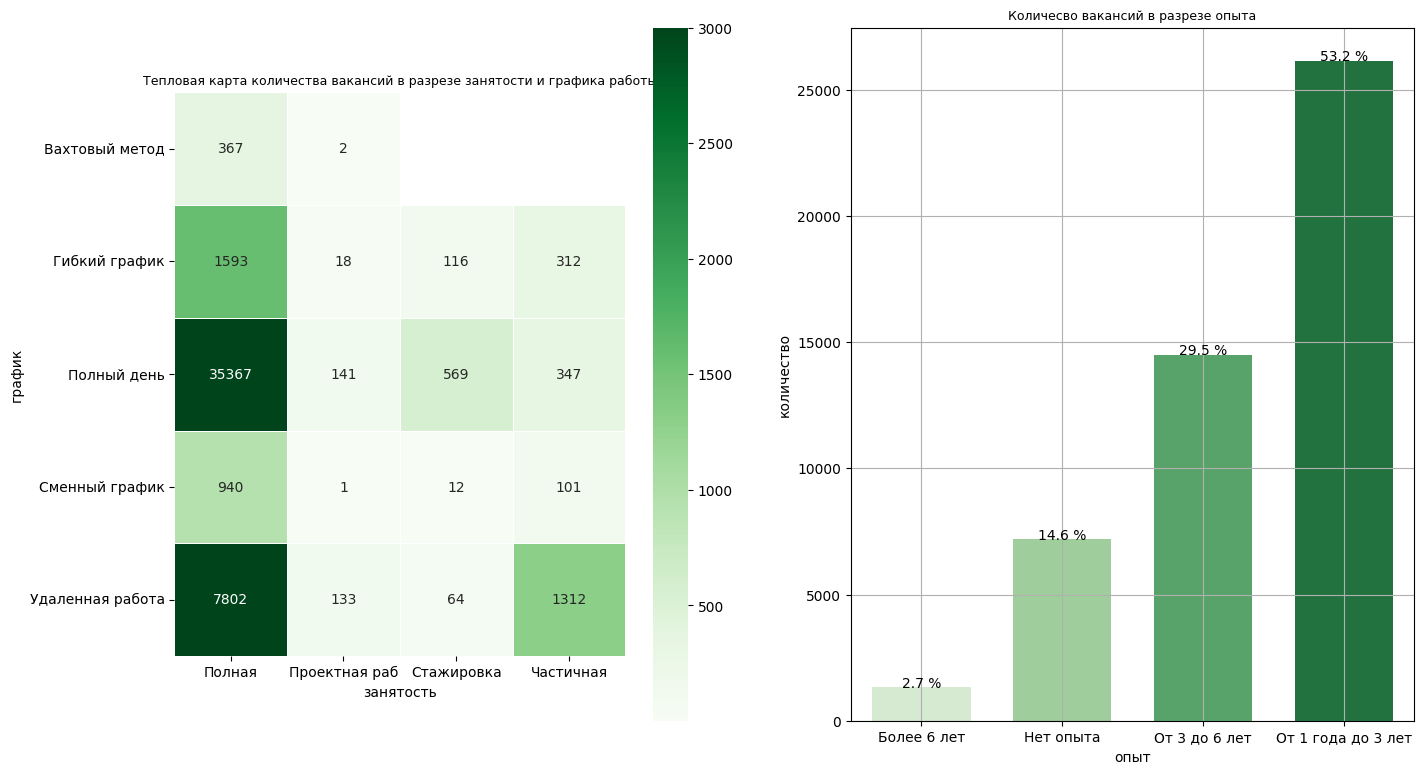

In [27]:
## построим графики, отражающие количество вакансий в разрезе занятости и графика работы, а также в разрезе опыта
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

heatmap = sns.heatmap(
    data=schedule_emloyment_cnt.pivot_table(
    values='count',
    index='schedule',
    columns='employment'
    ), 
    cmap='Greens',
    vmax=3000, 
    square=True,
    xticklabels=['Полная', 'Проектная раб','Стажировка','Частичная'],
    linewidths=0.5, 
    annot=True,
    fmt='.0f',
    ax=axes[0]
    )
heatmap.set(xlabel='занятость', ylabel='график')
heatmap.set_title('Тепловая карта количества вакансий в разрезе занятости и графика работы', fontsize=9);

barplot = sns.barplot(
    data=experience_cnt,
    x='experience',
    y='count',
    width=0.7,
    errorbar=None,
    palette='Greens',
    ax=axes[1]
)
for index, value in enumerate(experience_cnt['count']):
    plt.text(index, value, str(round(value/49197*100, 1))+' %', ha='center')
barplot.grid()
barplot.set(xlabel='опыт', ylabel='количество')
barplot.set_title('Количесво вакансий в разрезе опыта', fontsize=9);

1. Наибольшое количество вакансий представлено в Москве(более 10%), также стоит отметить, что только в 23 регионах количество заявок больше 1% от общего количества заявок (19 из 23 регионов являются городами-миллионниками), в этих регионах сосредоточено более 60% вакансий. Для подобора вакансии стоит предложить соискателям дополнительно рассмотреть вакансии в ближайшем крупном городе. 
2. Зарплатная вилка по среднему значению составляет от 71 тыс. руб. до 110.5 тыс. руб., при этом работодатели указывали нижнее или верхнее значение зарплаты в 24073 вакансиях (чуть менее половины). Соискателям стоит дополнительно предложить к выбру вакансии без указания границ зарплаты.
3. В более 70% вакансий работодатели предлагают - полную занятость и полный день(35367 вакансий), на полную занятость и удаленную работу ищут в 7802 вакансиях, чуть больше 3%(1593) вакансий предлагают соискателям гибкий график на полной занятости и чуть меньше 3%(1312) на удаленную работу с частичной занятостью. Также стоит отметить, что сочетание полной занятости и сменного графика предлагают в 940 вакансиях, а стажировку на полный день в 569. Остальные сочетания занятости и рабочего графика не набирают и 1% от общего количества вакансий, при этом также выделяются вакансии при проектной работе и сменном графике (1) и вахтовом методе (2), которые скорее всего являются выбросами, так как сложно представить проектную работу по сменно или вахтовым методом.
4. Распределение по запрашиваемому опыту сложилось следующим образом: в более половине вакансий требуется опыт от 1 года до 3 лет, около 30%  - это вакансии с опытом от 3 до 6 лет, без опыта работодатели ищут в 7197 вакансиях(около 15%) и в менее чем в 3% вакансиях указан опыт более 6 лет. Вероятно, это связано с тем, что соискатели, имеющие опыт более 6 лет, уже закрепились в отрасле и предпочитают либо оставаться на своем рабочем месте, либо искать новое местом благодоря нетворкингу. В то время как соискатели с опытом от 1 до 3 лет, получив определенные навыки, но еще не сильно закрепившись в отрасли, пользуются сервисами подбора вакансий.

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [28]:
# текст запроса
query_5_1 = f'''select 
                    count(v.id),
                    e.name
                from public.vacancies as v
                    left join public.employers as e on v.employer_id = e.id
                group by e.id
                order by count(e.id) desc
                limit 5        
            '''

In [29]:
# результат запроса
top_employers = pd.read_sql_query(query_5_1, connection)
top_employers

,count,name
0,1933,Яндекс
1,491,Ростелеком
2,444,Тинькофф
3,428,СБЕР
4,331,Газпром нефть


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [30]:
# текст запроса
query_5_2 = f'''with x as
                (
                select 
                    a.name,
                    count(v.id) as vacancies_cnt,
                    a.id
                from public.areas as a
                    left join public.vacancies as v on a.id = v.area_id  
                group by a.id
                )
                select
                    x.name,
                    x.vacancies_cnt,
                    count(e.id) as employer_cnt
                from x
                    left join public.employers as e on x.id = e.area
                group by x.id, x.name, x.vacancies_cnt
                order by x.vacancies_cnt asc, count(e.id) desc              
            '''

In [31]:
# результат запроса
areas_vac_empl = pd.read_sql_query(query_5_2, connection)
areas_vac_empl 

,name,vacancies_cnt,employer_cnt
0,Россия,0,410
1,Казахстан,0,207
2,Московская область,0,75
3,Краснодарский край,0,19
4,Беларусь,0,18
...,...,...,...
1357,Алматы,1892,721
1358,Новосибирск,2006,573
1359,Минск,2112,1115
1360,Санкт-Петербург,2851,2217


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [32]:
# текст запроса
query_5_3 = f'''select
                    e.name,
                    count(distinct v.area_id) as area_cnt
                from public.vacancies as v
                    full join public.employers as e on v.employer_id = e.id
                group by e.id
                order by count(distinct v.area_id) desc          
            '''

In [33]:
# результат запроса
employer_area = pd.read_sql_query(query_5_3, connection)
employer_area

,name,area_cnt
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
...,...,...
23496,Но Смокинг,0
23497,МАСТЕРСКАЯ CREED,0
23498,Dzing Finance,0
23499,КОРС,0


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [34]:
# текст запроса
query_5_4 = f'''select
                    count(*)
                from public.employers e
                   left join public.employers_industries ei on e.id = ei.employer_id
                where ei.industry_id is null         
            '''

In [35]:
# результат запроса
employer_without_ind = pd.read_sql_query(query_5_4, connection)
employer_without_ind

,count
0,8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [36]:
# текст запроса
query_5_5 = f'''select
                    e.name,
                    count(ei.industry_id)
                from public.employers e
                   left join public.employers_industries ei on e.id = ei.employer_id
                group by e.id
                having  count(ei.industry_id) = 4
                order by e.name
                offset 2 limit 1      
            '''

In [37]:
# результат запроса
employer_with4_ind = pd.read_sql_query(query_5_5, connection)
employer_with4_ind

,name,count
0,2ГИС,4


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [38]:
# текст запроса
query_5_6 = f'''select
                    count(*)
                from public.employers_industries ei
                   join public.industries i on ei.industry_id = i.id
                where i.name = 'Разработка программного обеспечения'  
            '''

In [39]:
# результат запроса
num_soft_empl = pd.read_sql_query(query_5_6, connection)
num_soft_empl

,count
0,3553


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [40]:
# код для получения списка городов-милионников
url = 'https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8' # Задаём адрес ресурса
response = requests.get(url)
page = BeautifulSoup(response.text, 'html.parser')
page = page.find('table', class_='standard') 
page = page.find_all('a')
city_list = tuple(city.text for city in page[4:])
print(city_list)

('Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', 'Казань', 'Нижний Новгород', 'Красноярск', 'Челябинск', 'Самара', 'Уфа', 'Ростов-на-Дону', 'Краснодар', 'Омск', 'Воронеж', 'Пермь', 'Волгоград')


In [41]:
# текст запроса
query_5_7 = f'''with x as
                (
                select
                    a.name as city,
                    count(v.id) as vacancies_cnt
                from public.vacancies as v
                    join public.employers as e on v.employer_id = e.id
                    join public.areas as a on v.area_id = a.id
                where e.name = 'Яндекс'
                    and a.name in {city_list}
                group by a.id
                order by count(v.id) desc
                )
                select *
                from x
                
                union
                
                select
                    'total',
                    sum(x.vacancies_cnt)
                from x
                order by vacancies_cnt desc         
            '''

In [42]:
# результат запроса
yandex_city = pd.read_sql_query(query_5_7, connection)
yandex_city

,city,vacancies_cnt
0,total,485.0
1,Москва,54.0
2,Санкт-Петербург,42.0
3,Екатеринбург,39.0
4,Нижний Новгород,36.0
5,Новосибирск,35.0
6,Воронеж,32.0
7,Краснодар,30.0
8,Самара,26.0
9,Уфа,26.0


***

1. Не все работодатели указывают сферу деятельности, 8409 компаний из 23501 не указали( приблизительно 1/3). Многие работодатели имеют более одной сферы деятельности. Нектороые работодатели в качестве региона указывают более крупные территориальные формирования (области, страны). Самые крупные регионы по представительству работодателей коррелируют с распределением вакансий: Москва, Санкт-Петербург, Минск, Алматы.
2. По количеству вакансий лидируют компании: Яндекс, Ростелеком, Тинькофф, при этом вакнсий Яндекс  почти в 4 раза больше чем, занимающего второе место Ростелекома. По охвату регионов также лидирует Яндекс - 181 регион, Ростеликом - 152, Спецремонт - 116. При этом Яндекс представлен во всех городах миллионниках.
3. Рассмотрим какие сферы деятельности и компании подходят для DS специалистов.

In [43]:
# попробуем выяснить какие сферы деятельности подходят для DS специалистов
## отфилтруем датасет по встречающимчя в названии вакансии словосочетаниям
## также будем рассматривать сферы, в которых более одной такой вакансии 
query_5_8 = f'''select 
                    i.name,
                    i.id,
                    count(v.id) as vacancies_cnt
                from public.vacancies v
                    join public.employers e on v.employer_id = e.id
                    join public.employers_industries ei on e.id = ei.employer_id
                    join public.industries i on ei.industry_id = i.id
                where lower(v.name) like '%data scientist%'
                    or lower(v.name) like '%data science%'
                    or lower(v.name) like '%исследователь данных%'
                    or lower(v.name) like '%machine learning%'
                    or lower(v.name) like '%машинн%обучен%'
                    or (v.name like '%ML%' and v.name not like '%HTML%')
                group by i.id
                having count(v.id) > 1
                order by count(v.id) desc
            '''

ds_employers_industr = pd.read_sql_query(query_5_8, connection)
ds_employers_industr

,name,id,vacancies_cnt
0,Разработка программного обеспечения,7.540,148
1,"Системная интеграция, автоматизации технологи...",7.539,139
2,Банк,43.647,92
3,"Интернет-компания (поисковики, платежные систе...",7.541,79
4,Мобильная связь,9.399,23
5,"Маркетинговые, рекламные, BTL, дизайнерские, E...",11.459,22
6,"Управляющая, инвестиционная компания (управлен...",43.648,21
7,Консалтинговые услуги,44.393,16
8,Фиксированная связь,9.400,13
9,"Научно-исследовательская, научная, академическ...",39.441,9


Можно сделать вывод, что наибольшее количество вакансий относится к сфере IT, финансовых услуг, услуг связи, оптовой и розничной торговли. При этом ID сферы деятельности имеет хорошо структурированный код, в следствие чего, можно предположить, что коды начинающиеся с 7  это сферы напрямую связанные с IT.

In [44]:
query_5_9 = f'''select *
                    
                from public.industries
                where id like '7.%'
                '''

it_industr = pd.read_sql_query(query_5_9, connection)
it_industr

,id,name
0,7.540,Разработка программного обеспечения
1,7.539,"Системная интеграция, автоматизации технологи..."
2,7.541,"Интернет-компания (поисковики, платежные систе..."
3,7.538,Интернет-провайдер


In [45]:
# попробуем выяснить какие компании ищут DS специалистов
## отфилтруем датасет по встречающимчя в названии вакансии словосочетаниям
## также будем рассматривать организации, в которых более трех таких вакансий
query_5_10 = f'''select 
                    e.name,
                    count(v.id) as vacancies_cnt
                from public.vacancies v
                    join public.employers e on v.employer_id = e.id
                    where lower(v.name) like '%data scientist%'
                    or lower(v.name) like '%data science%'
                    or lower(v.name) like '%исследователь данных%'
                    or lower(v.name) like '%machine learning%'
                    or lower(v.name) like '%машинн%обучен%'
                    or (v.name like '%ML%' and v.name not like '%HTML%')
                group by e.id
                having count(v.id) > 3
                order by count(v.id) desc
                
            '''
ds_employer = pd.read_sql_query(query_5_10, connection)
ds_employer

,name,vacancies_cnt
0,СБЕР,37
1,Bell Integrator,25
2,Банк ВТБ (ПАО),18
3,VK,15
4,Positive Technologies,11
5,EvenBet Gaming,9
6,Яндекс,9
7,МегаФон,8
8,Andersen,7
9,МТС,6


Лидером является СБЕР, также в выборке представлены раработчики ПО и игр, банки, сотовые операторы, ретейлеры. Предположим, что это компании работающие с большими базами данных, большинство из них имеют свои экосистемы, в связи с чем у них чаще возникает необходимость расширять свои базы данных, проводить множество различных аналитических исследований.

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [46]:
# текст запроса
query_6_1 = f'''select count(*)
                from public.vacancies
                where lower(name) like '%data%'
                    or lower(name) like '%данн%'
            '''



In [47]:
# результат запроса
ds_vacancies_cnt = pd.read_sql_query(query_6_1, connection)
ds_vacancies_cnt

,count
0,1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [48]:
# текст запроса
query_6_2 = f'''select count(*) from
                (
                select *
                from public.vacancies
                where lower(name) like '%data scientist%'
                    or lower(name) like '%data science%'
                    or lower(name) like '%исследователь данных%'
                    or lower(name) like '%machine learning%'
                    or lower(name) like '%машинн%обучен%'
                    or (name like '%ML%' and name not like '%HTML%')
                intersect
                select *
                from public.vacancies
                where lower(name) like '%junior%'
                    or experience = 'Нет опыта'
                    or employment = 'Стажировка'
                ) as x
            '''

In [49]:
# результат запроса
ds_jun_vacancies_cnt = pd.read_sql_query(query_6_2, connection)
ds_jun_vacancies_cnt

,count
0,51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [50]:
# текст запроса
query_6_3 = f'''select count(*) from
                (
                select *
                from public.vacancies
                where lower(name) like '%data scientist%'
                    or lower(name) like '%data science%'
                    or lower(name) like '%исследователь данных%'
                    or lower(name) like '%machine learning%'
                    or lower(name) like '%машинн%обучен%'
                    or (name like '%ML%' and name not like '%HTML%')
                intersect
                select *
                from public.vacancies
                where key_skills like '%SQL%'
                    or lower(key_skills) like '%postgres%'
                ) as x
            '''

In [51]:
# результат запроса
ds_sql_vacancies_cnt = pd.read_sql_query(query_6_3, connection)
ds_sql_vacancies_cnt

,count
0,201


4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [52]:
# текст запроса
query_6_4 = f'''select count(*) from
                (
                select *
                from public.vacancies
                where lower(name) like '%data scientist%'
                    or lower(name) like '%data science%'
                    or lower(name) like '%исследователь данных%'
                    or lower(name) like '%machine learning%'
                    or lower(name) like '%машинн%обучен%'
                    or (name like '%ML%' and name not like '%HTML%')
                intersect
                select *
                from public.vacancies
                where lower(key_skills) like '%python%'
                ) as x
            '''

In [53]:
# результат запроса
ds_python_vacancies_cnt = pd.read_sql_query(query_6_4, connection)
ds_python_vacancies_cnt


,count
0,351


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [54]:
# текст запроса с учетком вакансий, где не указаны навыки
query_6_5 = f'''select round(avg(cnt), 2) from
                (
                select
                    length(key_skills) - length(replace(key_skills, '\t', '')) + 1 as cnt
                from public.vacancies
                where (lower(name) like '%data scientist%'
                    or lower(name) like '%data science%'
                    or lower(name) like '%исследователь данных%'
                    or lower(name) like '%machine learning%'
                    or lower(name) like '%машинн%обучен%'
                    or (name like '%ML%' and name not like '%HTML%'))
                    and key_skills is not null

                union all
                
                select 
                    0
                from public.vacancies
                where (lower(name) like '%data scientist%'
                    or lower(name) like '%data science%'
                    or lower(name) like '%исследователь данных%'
                    or lower(name) like '%machine learning%'
                    or lower(name) like '%машинн%обучен%'
                    or (name like '%ML%' and name not like '%HTML%'))
                    and key_skills is null
                )
                as x 
                
                 
            '''

In [55]:
# текст запроса: без учета вакансий, где не указаны навыки
query_6_5_1 = f'''select round(avg(cnt), 2) from
                (
                select
                    key_skills, 
                    length(key_skills) - length(replace(key_skills, '\t', '')) + 1 as cnt
                from public.vacancies
                where (lower(name) like '%data scientist%'
                    or lower(name) like '%data science%'
                    or lower(name) like '%исследователь данных%'
                    or lower(name) like '%machine learning%'
                    or lower(name) like '%машинн%обучен%'
                    or (name like '%ML%' and name not like '%HTML%'))
                    and key_skills is not null
                )
                as x 
            '''

In [56]:
# результат запроса
ds_skills_cnt_avg = pd.read_sql_query(query_6_5, connection)
display(ds_skills_cnt_avg)
ds_skills_cnt_avg_null = pd.read_sql_query(query_6_5_1, connection)
ds_skills_cnt_avg_null

,round
0,5.75


,round
0,6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [57]:
# текст 
query_6_6 = f'''select
                    experience,
                    round(avg((coalesce(salary_from, salary_to) + coalesce(salary_to, salary_from))/2)) as avg_salary,
                    count(id)
                from public.vacancies
                where (lower(name) like '%data scientist%'
                    or lower(name) like '%data science%'
                    or lower(name) like '%исследователь данных%'
                    or lower(name) like '%machine learning%'
                    or lower(name) like '%машинн%обучен%'
                    or (name like '%ML%' and name not like '%HTML%'))
                    --and (salary_from is not null or salary_to is not null)
                group by experience
                order by 2 desc
            '''

In [58]:
# результат запроса
ds_avg_salary= pd.read_sql_query(query_6_6, connection)
ds_avg_salary

,experience,avg_salary,count
0,Более 6 лет,NaN,34
1,От 3 до 6 лет,243115.0,195
2,От 1 года до 3 лет,139675.0,223
3,Нет опыта,74643.0,28


***

1. В датасете 480 вакансий, подходящих для DS специалиста. 
2. В среднем работодатели указывают 6 навыков, которыми должен обладать  DS специалист. Наиболее распространненные - владение Python  и SQL.
3. Средняя зарплата DS специалиста (исходя из вакансий, где указана верхняя или нижняя граница зарплаты - 62 вакансии) увличивается с опытом и составляет 75 тысяч рублей для специалистов без опыта и 243 тысячи рублей при опыте от 3 до 6 лет. Также стоит отметить, что для специалистов с опытом от 6 лет работодатели не указывали границы зарплаты, вероятно для таких специалистов работодатели предпочитают обговаривать уровень зарплат на собеседованиях, либо это связано с небольшой выборкой - 34 вакнсии с опытом более 6 лет и подходящих для DS спеуиалиста. При этом стоит отметить, что выборка в общем крайне мала - всего 62 вакнсии удовлетворяют условиям, из них только 7 для вакансий с отсутствием опыта.

# Общий вывод по проекту

Попробуем написать [функцию](function_for_search.ipynb), которая будет подобирать вакансии по заданным критериям соискателя. Для этого сфорулируем выводы, полученные в этом исследовании, которые будем применять для написания кфункции.

1. Наименования вакансий слабо структурированы из-за того, что работодатели по разному записывали даже одниковые должности. В связи с этим целесообразно, осуществлять поиск по наличию подстроки, указанной соискателем, в наименовании вакансии.
2. График работы, занятость и опыт четко структурированы и имееют по 4-5 категорий, поэтому по этим показателям соискателю можно предложить выбрать подходящуюю категорию, а для опыта указать количество лет опыта. Также стоит отметить, что подавляющее большинство вакансий находятся в категориях полная занятость и полный день, в связи с чем в остальных категориях выборка по вакансиям будет небольшой. Небходимо оставить возможность не указывать поля заняости и графика, чтобы у соискателя была возможность рассмотреть сразу все варианты графика и занятости.
3. Так как большинство вакансий расположено в крупных городах, необходимо соискателю дать возможность указать помимо города, в котором он ищет, еще и крупный город, в который он был бы готов ездить на работу (например город и областной центр), для увеличения выборки вакансий. Можно разделить на 2 отдельных датафрейма.
4. Поиск по сферам деятельности будет не информативен, так как у трети компаний не указана сфера деятельности. При этом вакансия может быть как в специфической для нее сфере деятельности, так и не в специфической (например аналитик данных может требоваться как сфре разработки ПО, так и в банковоской сфере, и в сфере аптечных продаж).
5. Поиск по конкретному работодателю существенно снизит выборку вакансий, поэтому его не стоит учитывать для формирования запроса. Хотя это может быть дополнительным фактором поиска в конкретных условиях (например желание работать в крупной компании).
6. Навыки, требуемые работодателями очень разнообразны и могут включать занчительное количество разных навыков, однако отсутствие какого-то из них не всегда означает отказ работодателя (возможно обучение сотрудника). При этом некоторые работодателю вообще не указывали требуемые навыки. Целесообразно сделать фильрацию по вхождению любого из указанного соискателем навыка и добавить вакансии, в которых навыки работодателем не указаны.
7. Показатель зарплаты (от или до) указала только половина работодателей, но это слишком важное требование при поиске работы, чтобы игнорировать его. Поэтому будем осуществлять фильтрацию по желаемой соискателем зарплаты, рассмотрев 4 случая вхождения в диапозон: 
  - запрашиваемая зарплата находится между верхней и нижней границей, указанной работодателем;
  - запрашиваемая зарплата выше нижней границы, при этом верхняя граница не указана;
  - запрашиваемая зарплата ниже верхней границы, при этом нижняя граница не указана;
  - обе границы работодателем не указаны.
Также сортировку можно произвести по зарплате в порядке убывания.
8. Для увеличения количества вакансий в выборке необходимо предусмотреть возможность игнорирования любого из показателей поиска. Также предусмотреть возможность написания соискателем требования в разных регистрах.
